### Imports

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import numpy as np
import math
import sys
import geopandas as gpd
import matplotlib.pyplot as plt

### Load data

#### Model data

In [78]:
county_or_tract = 'county' # 'tract' or 'county'
state = 'WA' # 'RI', 'WA', 'AR', 'AK'
k = 10  # Number of districts, {AK: 1, AR: 4, RI: 2, WA: 10}

distance_data = 'data/{}/{}_distances.csv'.format(state, county_or_tract)
population_data = 'data/{}/{}_population.txt'.format(state, county_or_tract)
features_data = 'data/{}/{}_features.csv'.format(state, county_or_tract)

In [79]:
dist_df = pd.read_csv(distance_data)
with open(population_data) as f:
    pop = f.read().splitlines()

pop_df = []
for p in pop[1:]:
    pop_df.append(p.split(' '))
pop_df = pd.DataFrame(pop_df, columns=["id", "pop"])

feature_df = pd.read_csv(features_data, header=None)

#### Vis data

In [80]:
if county_or_tract == 'county':
    path_to_shapefile = 'geo_files/{}_geo_files/{}/{}_counties'.format(state, county_or_tract, state)
    path_to_centers_shapefile = 'geo_files/{}_geo_files/{}/{}_centers'.format(state, county_or_tract, state)
else:
    path_to_shapefile = 'geo_files/{}_geo_files/{}/{}_tracts'.format(state, county_or_tract, state)
    path_to_centers_shapefile = 'geo_files/{}_geo_files/{}/{}_centers'.format(state, county_or_tract, state)

### Preprocessing

In [81]:
zero_matrix = np.zeros((len(feature_df), len(feature_df)))
adj_df = pd.DataFrame(zero_matrix)
id_map = {}
for i, id in enumerate(feature_df[0]):
    id_map[id] = i

In [82]:
for node, adj_list in zip(feature_df[0], feature_df[2]):
    node_idx = id_map[node]
    for adj in adj_list.split(','):
        try:
            adj_idx = id_map[int(adj[1:])]
        except KeyError:
            adj_idx = id_map[int(adj)]
        adj_df.iloc[node_idx, adj_idx] = 1
adj_matrix = adj_df.values

In [83]:
pop_df['pop'] = pd.to_numeric(pop_df['pop'], errors='coerce')

In [84]:
# convert adjacency matrix to graph
import networkx as nx
G = nx.Graph()
for i in range(len(feature_df[0])):
    G.add_node(i)
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        if adj_matrix[i, j] == 1:
            G.add_edge(i, j)

### Exact cut-based model

In [102]:
DG = nx.DiGraph(G)
model = Model("districting_model")
model._DG = DG
n = len(DG.nodes) 
population = [i for i in pop_df['pop'].values]
deviation = 3.9
L = math.ceil((1-deviation/2)*sum(population)/k)
U = math.floor((1+deviation/2)*sum(population)/k)
print("L =",L,", U =",U,", k =",k)

maxp = max(population[i] for i in G.nodes)
if k==1 or maxp>U:
    print("k=",k,", max{ p_v | v in V } =",maxp,", U =",U,end='.')
    sys.exit("Aborting early, either due to trivial instance or overtly infeasible instance.")

L = -732001 , U = 2273057 , k = 10


In [103]:
m = Model()
m._DG = DG
m._X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY)

# DG = m._DG
# Each vertex i assigned to one district
m.addConstrs(quicksum(m._X[i,j] for j in DG.nodes) == 1 for i in DG.nodes)
    
# Pick k centers
m.addConstr(quicksum(m._X[j,j] for j in DG.nodes) == k)

# Population balance: population assigned to vertex j should be in [L,U], if j is a center
m.addConstrs(quicksum(population[i] * m._X[i,j] for i in DG.nodes) <= U * m._X[j,j] for j in DG.nodes)
m.addConstrs(quicksum(population[i] * m._X[i,j] for i in DG.nodes) >= L * m._X[j,j] for j in DG.nodes)

# Add coupling inequalities for added model strength
couplingConstrs = m.addConstrs(m._X[i,j] <= m._X[j,j] for i in DG.nodes for j in DG.nodes)

# Make them user cuts
for i in DG.nodes:
    for j in DG.nodes:
        couplingConstrs[i,j].Lazy = -1

# Set branch priority on center vars
for j in DG.nodes:
    m._X[j,j].BranchPriority=1   

# Y[i,j] = 1 if edge {i,j} is cut
m._Y = m.addVars(G.edges, vtype=GRB.BINARY)

m.addConstrs( m._X[i,v]-m._X[j,v] <= m._Y[i,j] for i,j in G.edges for v in G.nodes)
m.setObjective(quicksum(m._Y), GRB.MINIMIZE )

m._callback = None
m._population = population
m._U = U
m._k = k
m._base = 'hess'
m._numLazyCuts = 0
m._numCallbacks = 0

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)

def most_possible_nodes_in_one_district(population, U):
    cumulative_population = 0
    num_nodes = 0
    for ipopulation in sorted(population):
        cumulative_population += ipopulation
        num_nodes += 1
        if cumulative_population > U:
            return num_nodes - 1
        
# compute big-M    
M = most_possible_nodes_in_one_district(m._population, m._U) - 1

m.addConstrs(quicksum(F[j,u,j] for u in DG.neighbors(j)) == 0 for j in DG.nodes)
m.addConstrs(quicksum( F[j,u,i]-F[j,i,u] for u in DG.neighbors(i) ) == m._X[i,j] for i in DG.nodes for j in DG.nodes if i!=j)
m.addConstrs(quicksum( F[j,u,i] for u in DG.neighbors(i) ) <= M * m._X[i,j] for i in DG.nodes for j in DG.nodes if i!=j)

m.setParam(GRB.Param.TimeLimit, 4800)
m.optimize()

# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print('The model is infeasible; computing IIS')
    model.computeIIS()
    model.write("model.ilp")

# Output the results
for v in model.getVars():
    if v.x > 0.5:
        print(f"{v.varName}: {v.x}")

Set parameter TimeLimit to value 4800
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8230 rows, 8789 columns and 42454 nonzeros
Model fingerprint: 0x55fcd880
Variable types: 7176 continuous, 1613 integer (1613 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Using branch priorities.


C:\Users\20193217\AppData\Local\Temp\ipykernel_29288\1005765552.py:32: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  m.setObjective(quicksum(m._Y), GRB.MINIMIZE )


Presolve removed 2073 rows and 895 columns
Presolve time: 0.17s
Presolved: 6157 rows, 7894 columns, 34368 nonzeros
Crushed 1406 out of 1521 user cuts to presolved model
Variable types: 6364 continuous, 1530 integer (1530 binary)

Root relaxation: objective 8.488288e+00, 6545 iterations, 1.30 seconds (1.34 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.48829    0 1210          -    8.48829      -     -    2s
H    0     0                      92.0000000    8.48898  90.8%     -    3s
     0     0   10.90133    0 1143   92.00000   10.90133  88.2%     -    5s
H    0     0                      51.0000000   10.90139  78.6%     -    5s
H    0     0                      47.0000000   10.90139  76.8%     -    6s
     0     0   11.79462    0 1092   47.00000   11.79462  74.9%     -    7s
     0     0   12.06705    0  989   47.00000   12.06705  74.3%     -    9s
    

In [ ]:
labels = [ j for j in DG.nodes if m._X[j,j].x > 0.5 ]
# result['UFixings_R'] = 'n/a'
districts = [ [ i for i in DG.nodes if m._X[i,j].x > 0.5 ] for j in labels]
print("best solution (found) =",districts)

best solution (found) = [[0], [1, 2, 3, 4]]


In [ ]:
print(len(DG.nodes))

5


### Visualization

In [70]:
def create_cluster_list(clusters):
    # Find the maximum number to determine the size of the cluster list
    max_number = max(max(cluster) for cluster in clusters)
    # Initialize the cluster list with a placeholder indicating unassigned
    cluster_list = [-1] * (max_number + 1)
    # Populate the cluster list with the cluster numbers
    for cluster_number, cluster in enumerate(clusters):
        for number in cluster:
            cluster_list[number] = cluster_number
    return cluster_list

# Generate the cluster list
cluster_list = create_cluster_list(districts)
print(cluster_list)

[0, 1, 1, 1, 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


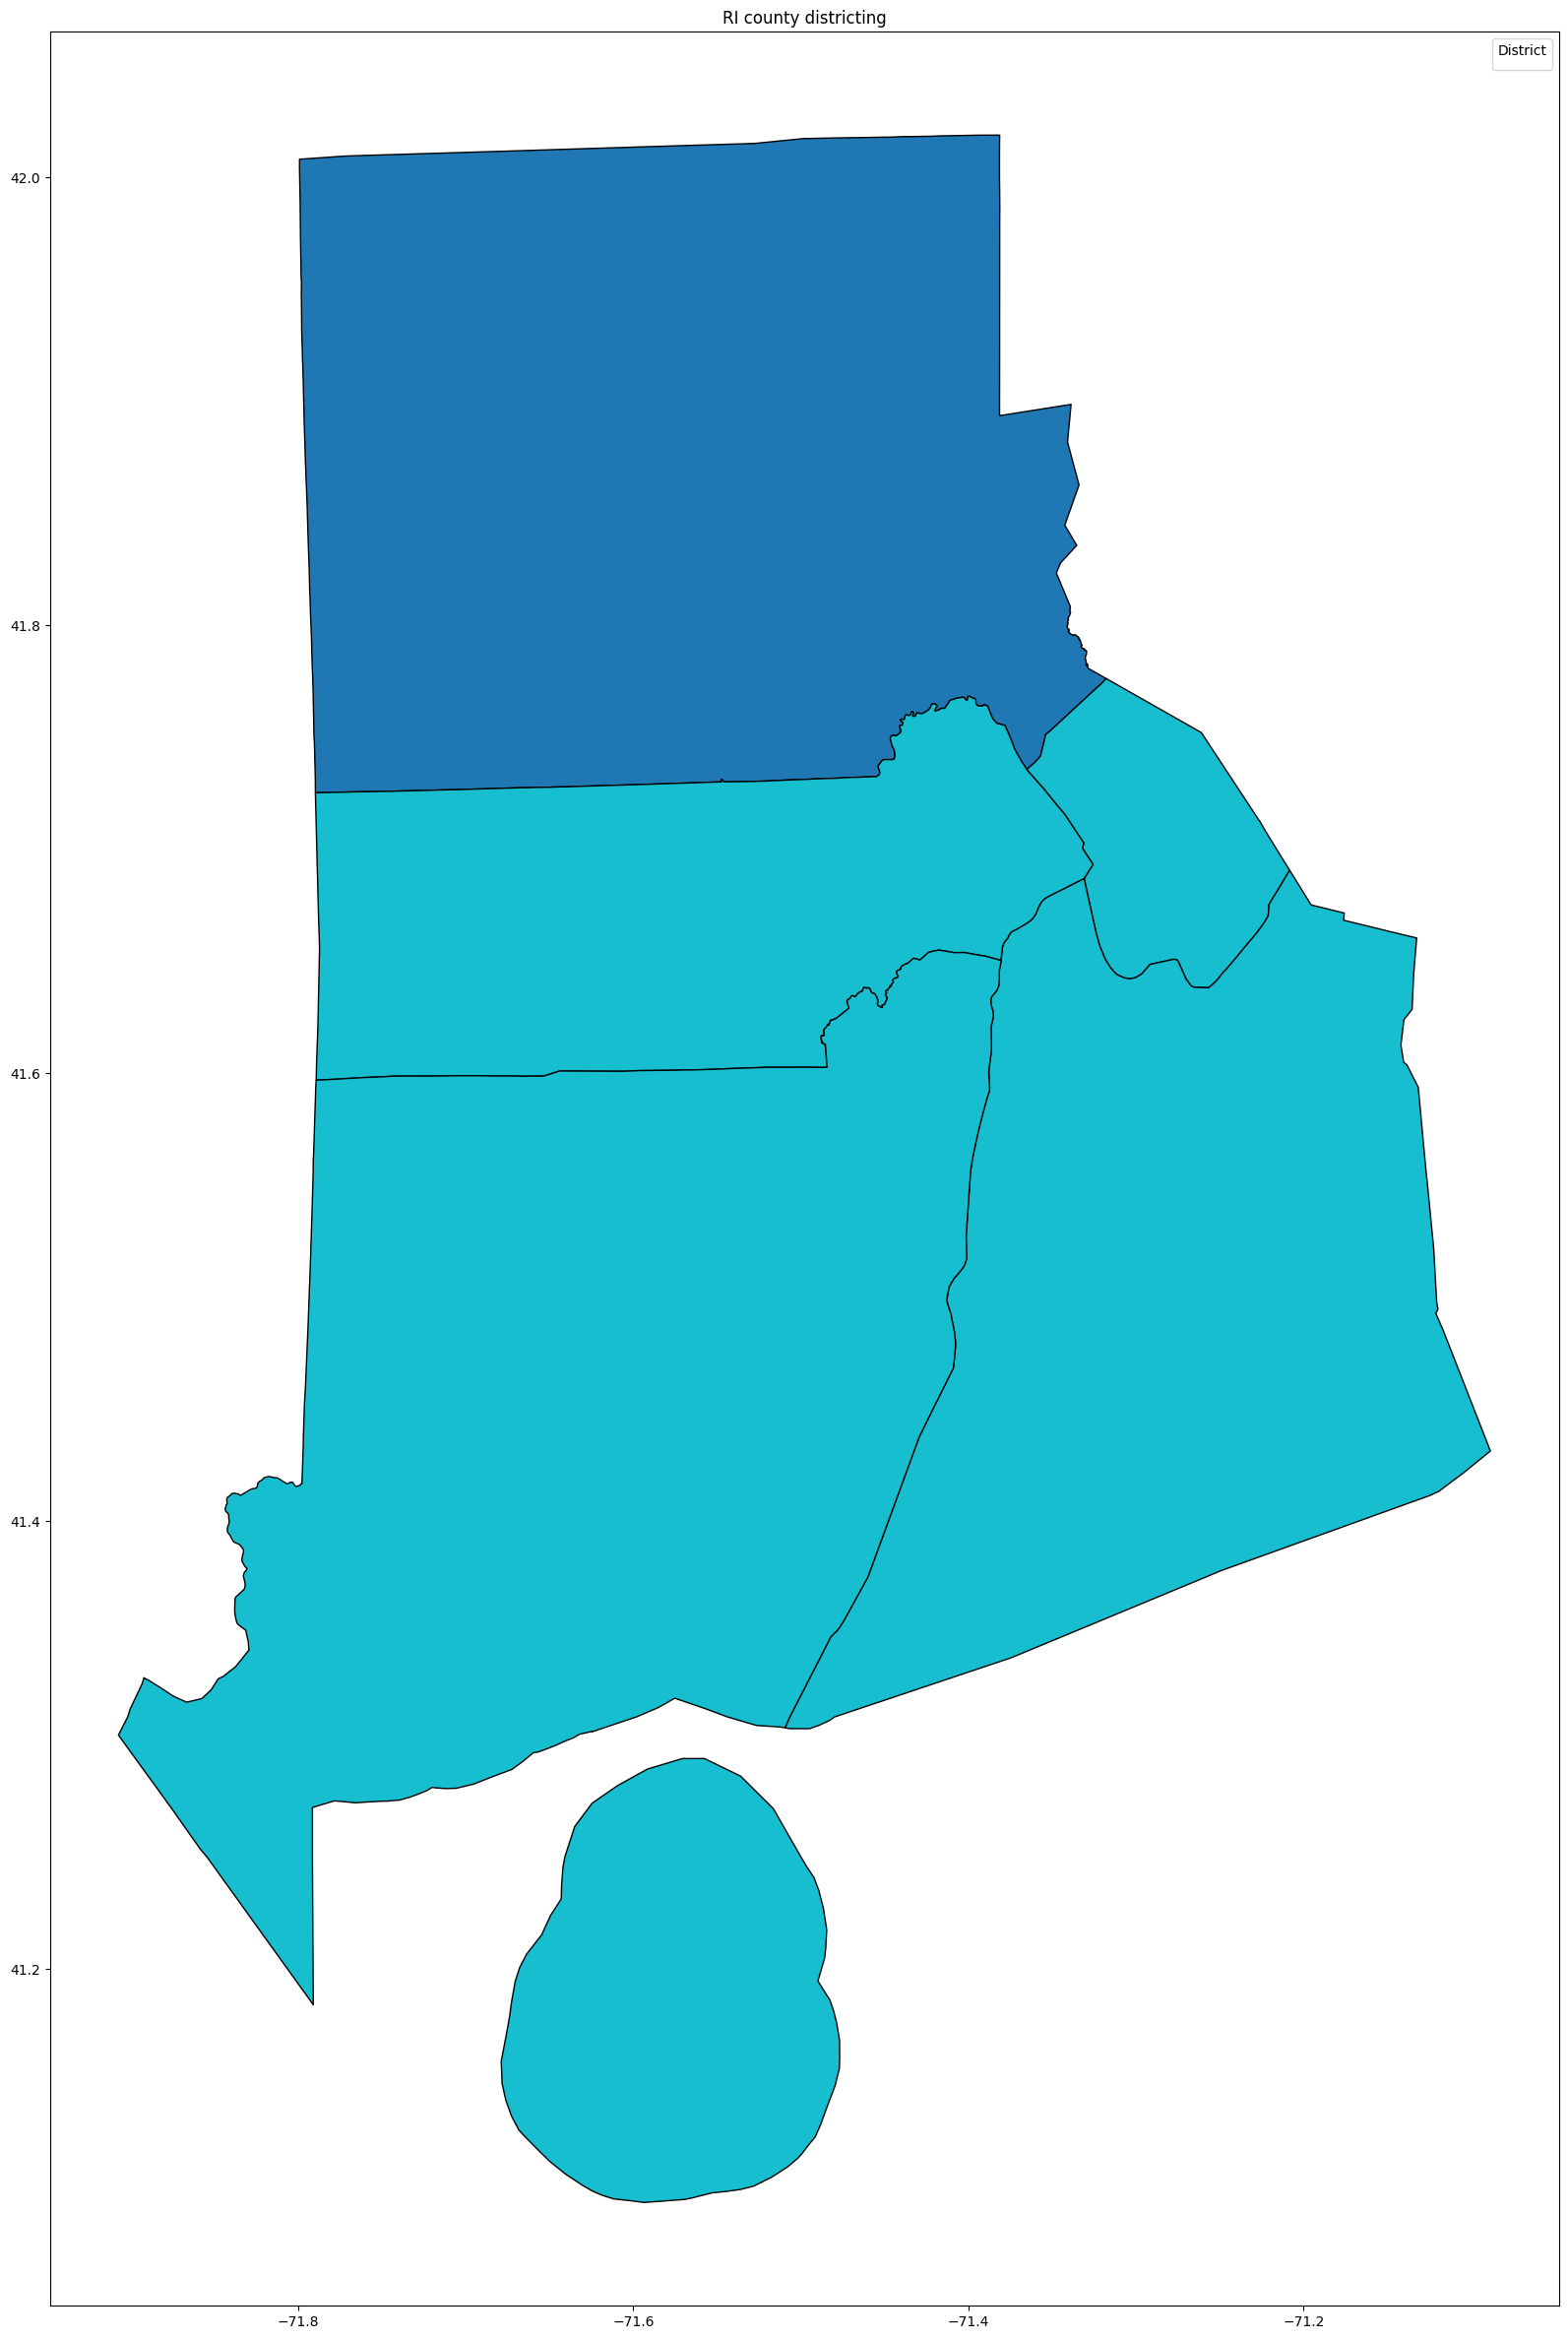

In [72]:
gdf_counties_or_tracts = gpd.read_file(f"{path_to_shapefile}.shp")
gdf_centers = gpd.read_file(f"{path_to_centers_shapefile}.shp")

gdf_centers['cluster'] = cluster_list
# gdf_centers = gdf_centers.merge(pop_df, left_on='id', right_on='id')
gdf_centers = pd.concat([gdf_centers, pop_df], axis=1, join='inner')
gdf_centers['markersize'] = gdf_centers['pop'].astype(int) / gdf_centers['pop'].astype(int).max() * 500 

# Merge cluster assignments to counties
gdf_counties_or_tracts = gdf_counties_or_tracts.merge(gdf_centers[['GEOID20', 'cluster']], on='GEOID20')

# Plot the counties with colors based on the cluster assignments
fig, ax = plt.subplots(figsize=(20, 30))
gdf_counties_or_tracts.plot(ax=ax, column='cluster', categorical=True, legend=True, edgecolor='black')

# Annotate the plot with the node numbers
# for x, y, label in zip(gdf_centers.geometry.x, gdf_centers.geometry.y, gdf_centers.index):
#     ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points")

# Optional: Add legend title
ax.legend(title='District')
# ax.set_xlim(-180,-90)

# add title
plt.title(f'{state} {county_or_tract} districting')

plt.show()

### Results

In [73]:
# Initialize the dictionary
x = {}

# Populate the dictionary
for district, nodes in enumerate(districts):
    for node in nodes:
        for k in range(len(districts)):
            x[node, k] = 1 if k == district else 0

In [74]:
K = len(districts)
print(K)

2


In [75]:
# Calculate the total population and the expected population per district
total_population = pop_df['pop'].sum()
expected_population = total_population / K

# Calculate the actual population per district
actual_population = [pop_df.loc[nodes]['pop'].sum() for nodes in districts]

# Calculate the RMSE of the population per district
rmse_population = round(np.sqrt(np.mean([(actual - expected_population) ** 2 for actual in actual_population])))

# Calculate the number of cut edges
cut_edges = 0
for edge in G.edges:
    if cluster_list[edge[0]] != cluster_list[edge[1]]:
        cut_edges += 1

print(f"RMSE of population per district: {rmse_population}")
print(f"Number of cut edges: {cut_edges}")

RMSE of population per district: 112052
Number of cut edges: 2


In [76]:
# Initialize the sum of distances
sum_of_distances = 0

# Iterate over each district
for district in districts:
    # Iterate over each pair of nodes in the district
    for i in range(len(district)):
        for j in range(i+1, len(district)):
            # Add the distance between the pair of nodes to the sum of distances
            sum_of_distances += dist_df.loc[district[i], str(district[j])]

print(f"Sum of distances within districts: {sum_of_distances}")

Sum of distances within districts: 185


### Metrics

In [77]:
# Calculate the total population and the expected population per district
total_population = pop_df['pop'].sum()
expected_population = total_population / K

# Calculate the actual population per district
actual_population = [pop_df.loc[nodes]['pop'].sum() for nodes in districts]

# Calculate the average relative difference between actual and mean population per district
avg_rel_diff_population = np.mean([abs(actual - expected_population) / expected_population for actual in actual_population])

# Calculate the RMSE of the population per district
rmse_population = round(np.sqrt(np.mean([(actual - expected_population) ** 2 for actual in actual_population])))

# Calculate the number of cut edges
cut_edges = 0
for edge in G.edges:
    if cluster_list[edge[0]] != cluster_list[edge[1]]:
        cut_edges += 1

print(f"Average relative difference of population per district: {avg_rel_diff_population * 100:.2f}%")
print(f"RMSE of population per district: {rmse_population}")
print(f"Number of cut edges: {cut_edges}")

Average relative difference of population per district: 20.42%
RMSE of population per district: 112052
Number of cut edges: 2
